# Name:- Pratik Zodpe
# PRN:- 240340143005

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

#import torch.nn.functional as F
#from torch.autograd import Variable

from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from helper import fn_plot_torch_hist, fn_plot_confusion_matrix, fn_plot_torch_hist

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
inpDir = os.path.join( '..', 'input')


###moduleDir = 'MACHINE LEARNING'

outDir = os.path.join('output')
modelDir = './Neural Network/Model'
subDir = 'flower_photos'
altName = 'flowers'


# define and set random state 
RANDOM_STATE = 24
#np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

ALPHA = 0.001     # learning rate
EPOCHS = 500
BATCH_SIZE = 32
TRAIN_SIZE = 92*BATCH_SIZE

IMG_WIDTH = 188
IMG_HEIGHT = 188

PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

EPSILON = 1e-8      # min significant difference


# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

#TEST_SIZE=0.2

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

<Figure size 1500x600 with 0 Axes>

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.version.cuda

'11.7'

In [5]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 2060 SUPER'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Helper Function

In [7]:
def fn_imshow(image, ax = None, title = None, normalize = True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std*image + mean
        image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    #----- Little beautification
    # switch off all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis = 'both', length = 0)
    
    # No tick labels
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [8]:
transform = transforms.Compose([transforms.Resize(IMG_HEIGHT),
                                transforms.CenterCrop(IMG_HEIGHT),
                                transforms.RandomHorizontalFlip(p = 0.5),
                                transforms.RandomVerticalFlip(p = 0.5),
                                transforms.RandomRotation(degrees = (-45,45)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = np.array([0.485, 0.456, 0.406]),
                                                            std = np.array([0.229, 0.224, 0.225]))])
                    
'''You can add as many data augmentations as you want'''

'You can add as many data augmentations as you want'

In [9]:
data_dir = os.path.join(inpDir, subDir)

dataset = datasets.ImageFolder(data_dir, transform = transform)

In [10]:
dataset

Dataset ImageFolder
    Number of datapoints: 3670
    Root location: ..\input\flower_photos
    StandardTransform
Transform: Compose(
               Resize(size=188, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(188, 188))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [11]:
image, label = next(iter(dataset))

image.shape, label

(torch.Size([3, 188, 188]), 0)

In [12]:
dataset_size = len(dataset)
train_size = TRAIN_SIZE
test_size = dataset_size - train_size
print(train_size, test_size)

2944 726


In [13]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

len(train_dataset), len(test_dataset)

(2944, 726)

In [14]:
class_labels = {}

for k in train_dataset.dataset.class_to_idx:
    print(k, train_dataset.dataset.class_to_idx[k])
    class_labels[train_dataset.dataset.class_to_idx[k]] = k
    
class_labels

daisy 0
dandelion 1
roses 2
sunflowers 3
tulips 4


{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [15]:
trainloader = DataLoader(train_dataset, 
                         batch_size = BATCH_SIZE, 
                         shuffle = True)

testloader = DataLoader(test_dataset, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True)                        

In [16]:
trainloader.dataset

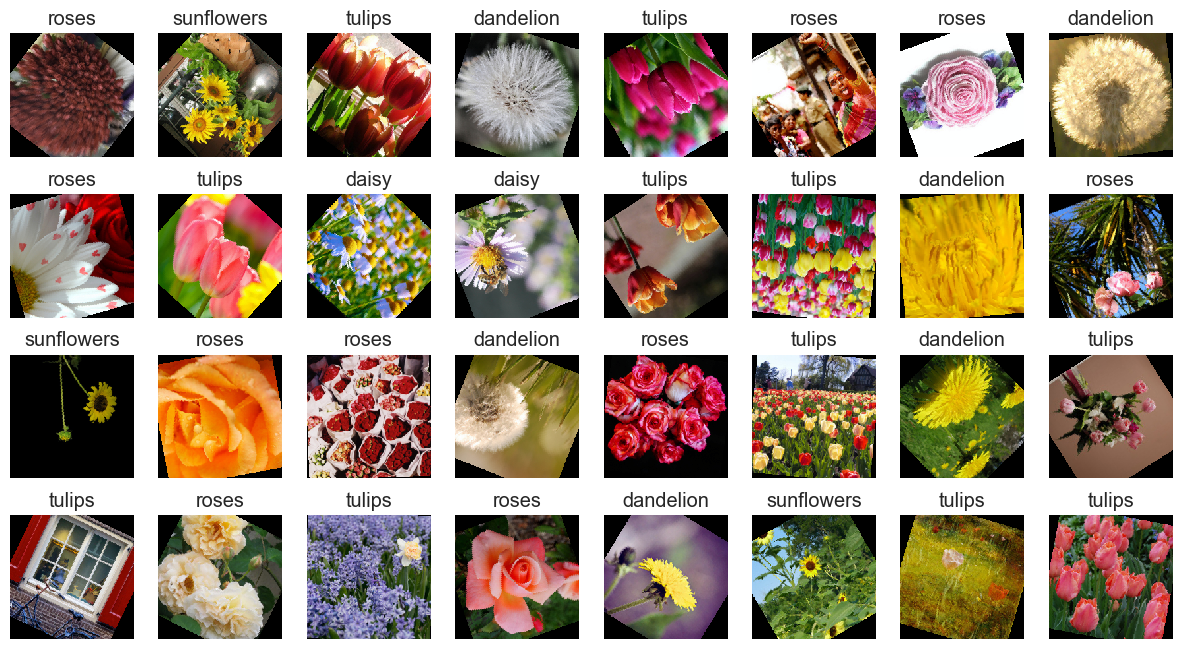

In [17]:
images, labels = next(iter(trainloader))

fig = plt.figure(figsize = (15,8))

for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE // 8, 8, (i + 1), xticks = [], yticks = [])
    fn_imshow(images[i], ax = ax, normalize = True)
    ax.set_title(class_labels[labels[i].item()])

In [18]:
testloader.dataset

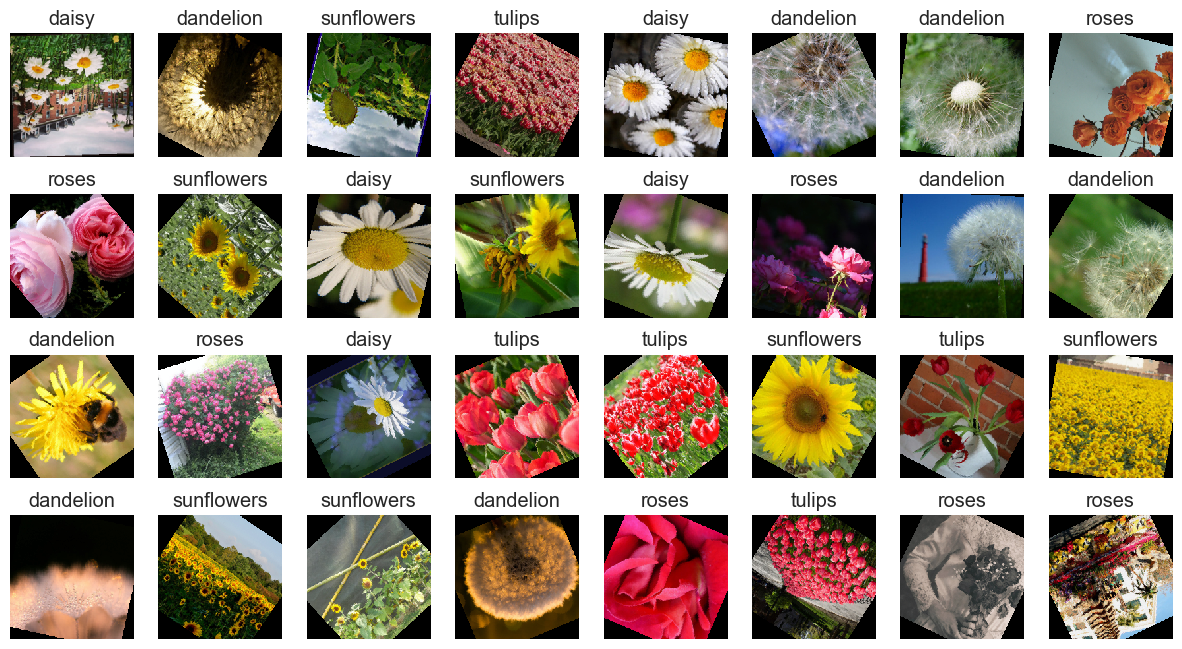

In [19]:
images, labels = next(iter(testloader))

fig = plt.figure(figsize = (15,8))

for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE // 8, 8, (i + 1), xticks = [], yticks = [])
    fn_imshow(images[i], ax = ax, normalize = True)
    ax.set_title(class_labels[labels[i].item()])

In [20]:
numChannels = 3

numClasses = len(class_labels)

trainSteps = len(trainloader.dataset) // BATCH_SIZE

testSteps = len(testloader.dataset) // BATCH_SIZE

trainSteps, testSteps

(92, 22)

### Define Model

In [21]:
class LeNet(nn.Module):
    def __init__(self, numChannels, classes):

    # call parent's constructor
        super(LeNet, self).__init__()
        
        # Dropouts
        dor1 = 0.1
        dor2 = 0.15
        dor3 = 0.20
        dor4 = 0.25
        dor5 = 0.35
        dor6 = 0.40
        dor7 = 0.50
        
        ## Define Layers
        
        ### Set 01 ###
        out_channels1 = 32
        
         # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv1 = nn.Conv2d(in_channels = numChannels, 
                               out_channels = out_channels1,
                               padding = 'same',
                               bias = False,
                               kernel_size = (3,3))         # output_shape = 188 x 188 x 32
        
        self.bn1 = nn.BatchNorm2d(out_channels1)
        self.actv1 = nn.LeakyReLU(inplace = True)
        self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))     # output_shape = 94 x 94 x 32
        self.dropout1 = nn.Dropout(p = dor1)
        
        
        
        
        ### Set 02 ###
        out_channels2 = 64
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv2 = nn.Conv2d(in_channels = out_channels1, 
                               out_channels = out_channels2,
                               bias = False,
                               kernel_size = (3,3))         # output_shape = 92 x 92 x 64
        
        self.bn2 = nn.BatchNorm2d(out_channels2)
        self.actv2 = nn.LeakyReLU(inplace = True)
        self.maxpool2 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))     # output_shape = 46 x 46 x 128
        self.dropout2 = nn.Dropout(p = dor2)
        
        
        
        
        ### Set 03 ###
        out_channels3 = 128
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv3 = nn.Conv2d(in_channels = out_channels2, 
                               out_channels = out_channels3,
                               bias = False,
                               kernel_size = (3,3))         # output_shape = 44 x 44 x 128
        
        self.bn3 = nn.BatchNorm2d(out_channels3)
        self.actv3 = nn.LeakyReLU(inplace = True)
        self.maxpool3 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))     # output_shape = 22 x 22 x 128
        self.dropout3 = nn.Dropout(p = dor3)
        
        
        
        ### Set 04 ###
        out_channels4 = 256
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv4 = nn.Conv2d(in_channels = out_channels3, 
                               out_channels = out_channels4,
                               bias = False,
                               kernel_size = (3,3))         # output_shape = 20 x 20 x 256
        
        self.bn4 = nn.BatchNorm2d(out_channels4)
        self.actv4 = nn.LeakyReLU(inplace = True)
        self.maxpool4 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))     # output_shape = 10 x 10 x 256
        self.dropout4 = nn.Dropout(p = dor4)
        
        
        
        ### Set 05 ###
        out_channels5 = 512
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv5 = nn.Conv2d(in_channels = out_channels4, 
                               out_channels = out_channels5,
                               bias = False,
                               kernel_size = (3,3))         # output_shape = 8 x 8 x 512
        
        self.bn5 = nn.BatchNorm2d(out_channels5)
        self.actv5 = nn.LeakyReLU(inplace = True)
        self.maxpool5 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))     # output_shape = 4 x 4 x 512
        self.dropout5 = nn.Dropout(p = dor5)
        
        
        
        ### Set 06 ###
        out_channels6 = 1024
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv6 = nn.Conv2d(in_channels = out_channels5, 
                               out_channels = out_channels6,
                               bias = False,
                               kernel_size = (3,3))         # output_shape = 2 x 2 x 1024
        
        self.bn6 = nn.BatchNorm2d(out_channels6)
        self.actv6 = nn.LeakyReLU(inplace = True)
        self.dropout6 = nn.Dropout(p = dor6)
        
        
        ############
        ### Head ###
        out_channels7 = 512
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.fc1 = nn.Linear(in_features = 2 * 2 * out_channels6, 
                               out_features = out_channels7,         # output_shape = 128
                               bias = False)
        self.bn7 = nn.BatchNorm1d(out_channels7)
        self.actv7 = nn.LeakyReLU(inplace = True)
        self.dropout7 = nn.Dropout(p = dor7)
        
        ### Final output layer
        self.fc2 = nn.Linear(in_features = out_channels7, 
                               out_features = classes,
                             bias = False)       # output_shape = 5
        self.logSoftmax = nn.LogSoftmax(dim = 1)
        
        
    def forward(self, x):
        
        # pass through 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        # pass through 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        # pass through 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.actv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        # pass through 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.actv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x)
        
        # pass through 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.actv5(x)
        x = self.maxpool5(x)
        x = self.dropout5(x)
        
        # pass through 6
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.actv6(x)
        
        x = torch.flatten(x, 1)
        
        # Head Fully Connected Layers
        x = self.fc1(x)
        x = self.bn7(x)
        x = self.actv7(x)
        x = self.dropout7(x)
        
        # Output
        x = self.fc2(x)
        return self.logSoftmax(x)

In [22]:
model = LeNet(numChannels = numChannels, classes = numClasses).to(device)
model = model.to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv1): LeakyReLU(negative_slope=0.01, inplace=True)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv2): LeakyReLU(negative_slope=0.01, inplace=True)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.15, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv3): LeakyReLU(negative_slope=0.01, inplace=True)
  (maxpool3): MaxPool2d(kernel_size=(

In [23]:
summary(model, input_size = (3, 188, 188))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 188, 188]             864
       BatchNorm2d-2         [-1, 32, 188, 188]              64
         LeakyReLU-3         [-1, 32, 188, 188]               0
         MaxPool2d-4           [-1, 32, 94, 94]               0
           Dropout-5           [-1, 32, 94, 94]               0
            Conv2d-6           [-1, 64, 92, 92]          18,432
       BatchNorm2d-7           [-1, 64, 92, 92]             128
         LeakyReLU-8           [-1, 64, 92, 92]               0
         MaxPool2d-9           [-1, 64, 46, 46]               0
          Dropout-10           [-1, 64, 46, 46]               0
           Conv2d-11          [-1, 128, 44, 44]          73,728
      BatchNorm2d-12          [-1, 128, 44, 44]             256
        LeakyReLU-13          [-1, 128, 44, 44]               0
        MaxPool2d-14          [-1, 128,

In [24]:
opt = torch.optim.Adam(model.parameters(), lr = ALPHA)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                       mode = 'min',
                                                       factor = LR_FACTOR,
                                                       patience = LR_PATIENCE)

loss_fn = nn.CrossEntropyLoss()

H = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': [],
    #'Alpha'   : [],
    #'Patience': []
}

In [25]:
minLoss = np.inf

counter = 0

savePath = os.path.join(modelDir, subDir, altName+'.pth')

In [26]:
print(f'Number of parameter: {len(list(model.parameters()))}')

Number of parameter: 22


In [27]:
for epoch in range(EPOCHS):
    
    model.train() # set your model in train mode
    
    # Initialize
    totalTrainLoss = 0
    totalTestLoss = 0
    trainCorrect = 0
    testCorrect = 0
    
    for(train_X, train_y) in trainloader:
        
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        
        pred = model(train_X)      # Make perdiction
    
        curr_loss = loss_fn(pred, train_y)     # Calculate loss
    
        ### Back Propogation 
        opt.zero_grad()
        curr_loss.backward()
        opt.step()
        totalTrainLoss += curr_loss
        trainCorrect += (pred.argmax(1) == train_y).type(torch.float).sum().item()
    
    with torch.no_grad():
        model.eval() # Do not update your weights
        
        for(test_X, test_y) in testloader:
        
            test_X = test_X.to(device)
            test_y = test_y.to(device)


            ts_pred = model(test_X)      # Make perdiction
            ts_curr_loss = loss_fn(ts_pred, test_y)

            totalTestLoss += ts_curr_loss
            testCorrect += (ts_pred.argmax(1) == test_y).type(torch.float).sum().item()
    
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    scheduler.step(totalTestLoss)
    
    #### Add Early Stopping
    if avgTestLoss < minLoss:
        minLoss = avgTestLoss
        counter = 0
        
        torch.save({'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': opt.state_dict(),
                   'loss': loss_fn,},'./Neural Network/Model')
        
    else:
        counter += 1
        
    if counter >= PATIENCE:
        break
    
    #------------------------------
    trainCorrect = trainCorrect / len(trainloader.dataset)
    testCorrect = testCorrect / len(testloader.dataset)
    
    H['epoch'].append(epoch)
    H['train_loss'].append(avgTrainLoss.cpu().item())
    H['test_loss'].append(avgTestLoss.cpu().item())
    H['train_acc'].append(trainCorrect)
    H['test_acc'].append(testCorrect)
    
    # print the model training and validation information
    print(f"[INFO] EPOCH: {epoch + 1} / {EPOCHS}", end = ' ')
    print(f"Loss: {avgTrainLoss:.6f}, Accuracy: {trainCorrect:.4f};", end = ' ')
    print(f"Test loss: {avgTestLoss:.6f}, Test accuracy: {testCorrect:.4f}")

[INFO] EPOCH: 1 / 500 Loss: 1.205217, Accuracy: 0.5071; Test loss: 1.377078, Test accuracy: 0.4559
[INFO] EPOCH: 2 / 500 Loss: 1.028666, Accuracy: 0.5924; Test loss: 1.189209, Test accuracy: 0.5565
[INFO] EPOCH: 3 / 500 Loss: 0.954443, Accuracy: 0.6247; Test loss: 1.240330, Test accuracy: 0.5634
[INFO] EPOCH: 4 / 500 Loss: 0.897168, Accuracy: 0.6501; Test loss: 1.062459, Test accuracy: 0.6129
[INFO] EPOCH: 5 / 500 Loss: 0.853807, Accuracy: 0.6654; Test loss: 1.057232, Test accuracy: 0.6226
[INFO] EPOCH: 6 / 500 Loss: 0.820450, Accuracy: 0.6868; Test loss: 0.997821, Test accuracy: 0.6391
[INFO] EPOCH: 7 / 500 Loss: 0.779187, Accuracy: 0.7021; Test loss: 0.941491, Test accuracy: 0.6694
[INFO] EPOCH: 8 / 500 Loss: 0.778418, Accuracy: 0.6984; Test loss: 0.893574, Test accuracy: 0.6584
[INFO] EPOCH: 9 / 500 Loss: 0.746179, Accuracy: 0.7120; Test loss: 0.880080, Test accuracy: 0.6543
[INFO] EPOCH: 10 / 500 Loss: 0.720955, Accuracy: 0.7293; Test loss: 0.814510, Test accuracy: 0.6970
[INFO] EP

[INFO] EPOCH: 84 / 500 Loss: 0.208702, Accuracy: 0.9226; Test loss: 0.537919, Test accuracy: 0.8320
[INFO] EPOCH: 85 / 500 Loss: 0.190194, Accuracy: 0.9317; Test loss: 0.500112, Test accuracy: 0.8333


In [28]:
loss_df = pd.DataFrame(H)
loss_df.head()

epoch  train_loss  test_loss  train_acc  test_acc
0      0        1.21       1.38       0.51      0.46
1      1        1.03       1.19       0.59      0.56
2      2        0.95       1.24       0.62      0.56
3      3        0.90       1.06       0.65      0.61
4      4        0.85       1.06       0.67      0.62

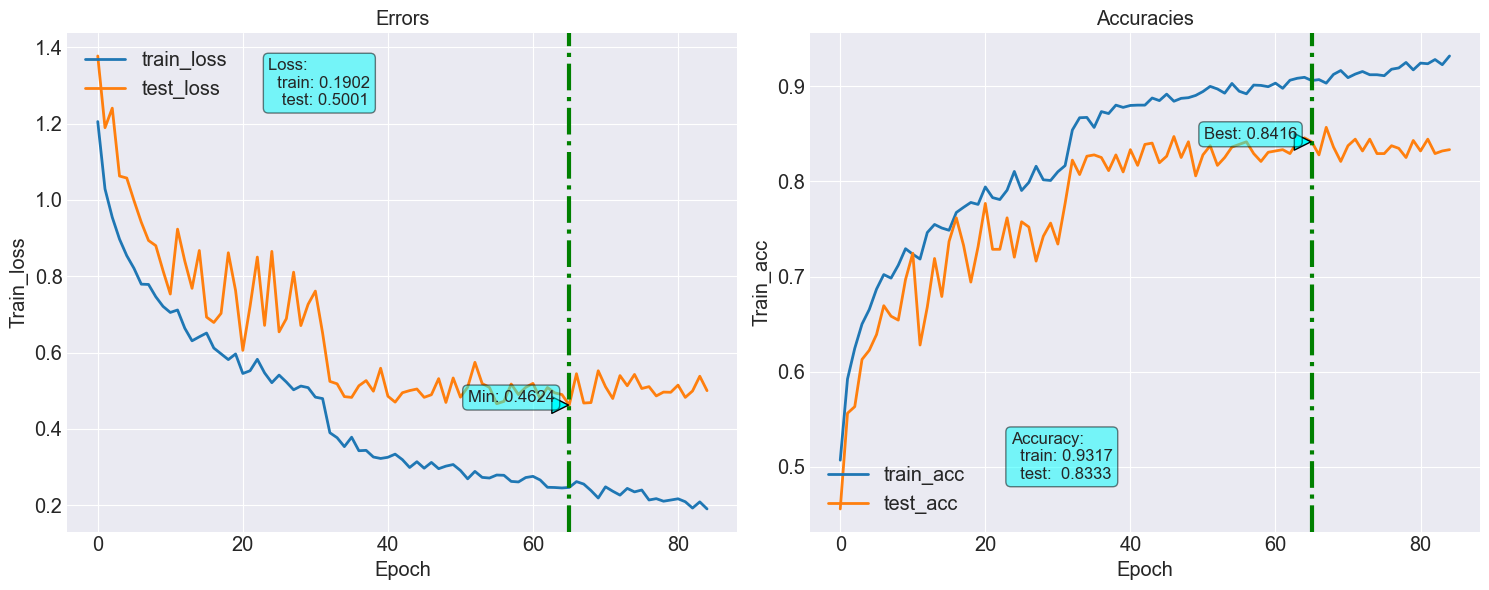

In [29]:
fn_plot_torch_hist(loss_df)

In [30]:
model_dict = torch.load('./Neural Network/Model')
model_dict.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])

In [31]:
model1 = LeNet(numChannels = numChannels, classes = numClasses).to(device)
model1.load_state_dict(model_dict['model_state_dict'])

<All keys matched successfully>

In [32]:
preds = []
labels = []

with torch.no_grad():
    model1.eval()
    
    for (test_X, test_y) in testloader:
        test_X = test_X.to(device)
        test_y = test_y.to(device)
        
        ts_pred = model(test_X)
        preds.extend(ts_pred.argmax(axis = 1). cpu().numpy())
        labels.extend(test_y.cpu().numpy())

In [33]:
accuracy_score(np.array(labels), np.array(preds))

0.8319559228650137

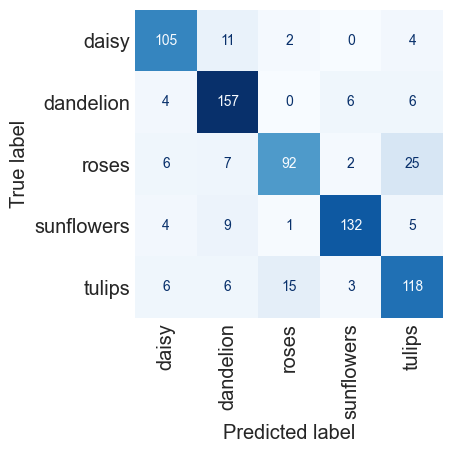

In [34]:
class_labels = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

fn_plot_confusion_matrix(np.array(labels), np.array(preds), class_labels)

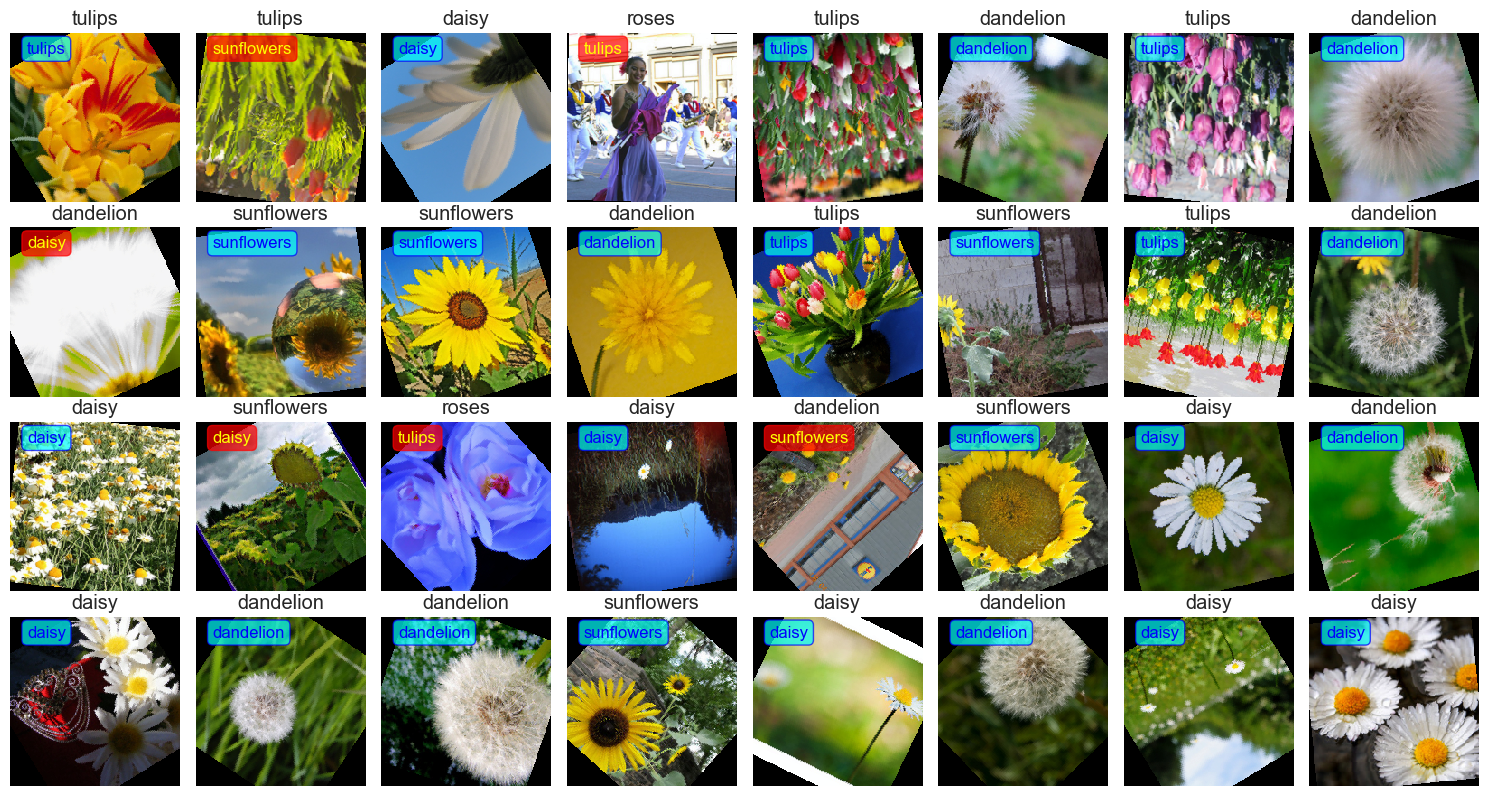

In [35]:
images, labels = next(iter(testloader))

images = images.to(device)
yhat = model(images)

y_pred = yhat.argmax(axis = 1).cpu().detach().numpy()
labels = labels

fig = plt.figure(figsize = (15,8))

fig.subplots_adjust(left = 0.,
                    right = 1.,
                    bottom = 0.,
                    top = 1.,
                    hspace = 0.05,
                    wspace = 0.05,)
fontsize = 12

for i in range(BATCH_SIZE):
    
    fc = 'cyan'
    ec = 'blue'
    text_color = 'blue'
    
    if labels[i] != y_pred[i]:
        fc = 'red'
        ec = 'red'
        text_color = 'yellow'
        
    props = dict(boxstyle = 'round', facecolor = fc, alpha = 0.7, ec = ec)
    
    ax = fig.add_subplot(BATCH_SIZE // 8, 8, (i + 1), xticks = [], yticks = [])
    
    fn_imshow(images[i].cpu(), ax = ax, normalize = True)
    
    ax.text(0.1, 0.95, class_labels[y_pred[i]], transform = ax.transAxes,
            fontsize = fontsize, color = text_color,
            verticalalignment = 'top', bbox = props)
    
    ax.set_title(class_labels[labels[i].item()])
    
    ax.axis('off')
    
plt.tight_layout()
plt.show()

### Looking at Validation Set

In [36]:
valid_transform = transforms.Compose([transforms.Resize(IMG_HEIGHT),
                                      transforms.CenterCrop(IMG_HEIGHT),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                           std = [0.229, 0.224, 0.225])])

In [38]:
#data_dir1 = os.path.join('flower_photos')
#dataset1 = datasets.ImageFolder(data_dir1, transform = valid_transform)

In [40]:
validloader = DataLoader(dataset, batch_size = BATCH_SIZE,shuffle = False)

In [42]:
with torch.no_grad():
    model1.eval()
    y_pred = []
    y_true = []
    for data in validloader:
        images, labels = data
        images = images.to(device)
        y_true.extend(labels)
        
        output = model1(images)
        y_pred.extend(output.argmax(axis = 1).cpu().numpy())

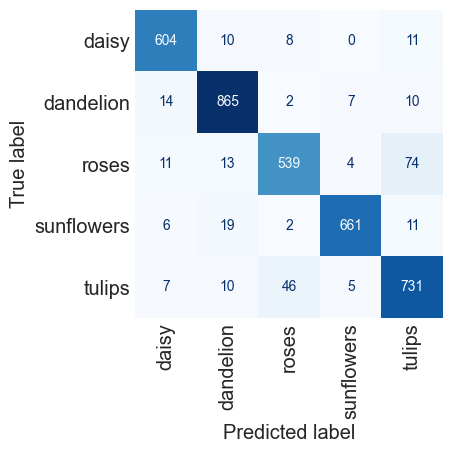

In [44]:
class_labels = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}
fn_plot_confusion_matrix(y_true, y_pred, class_labels)

### Conclusion

. While decreasing one layer, i got less accuracy. it shows me bad result.

. While taking Regularizer(L1, L2), it also shows me bad result.

. So I am taking all the layers and without taking regularizer i get good result(accuracy)